In [1]:
import os
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')
from MHS.F_model_training import *
from math import radians, cos, sin, asin, sqrt
from vision.misc.help_func import go_up_n_levels
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression, PoissonRegressor
from itertools import chain

from vision.tools.jupyter_notebooks import notebook_analysis_help_funcs
import importlib
importlib.reload(notebook_analysis_help_funcs)
from vision.tools.jupyter_notebooks.notebook_analysis_help_funcs import *

/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# CV sunside analysis after slicing

In [2]:
# or2009_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/OR2009/cv_features.csv"
BEERAMU0_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/BEERAMU0/cv_ps_features.csv"
ORSHICHT_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/ORSCHIST/cv_ps_features.csv"
# cv_features_paths = [or2009_cv_features, BEERAMU0_cv_features, ORSHICHT_cv_features]
cv_features_paths = [BEERAMU0_cv_features, ORSHICHT_cv_features]
cv_df = pd.concat([pd.read_csv(p) for p in cv_features_paths])

In [3]:
cv_df["row"] = cv_df["block_name"] + "_" + cv_df["name"].apply(lambda x: x.split("_")[0])
value_counts = cv_df['row'].value_counts()
valid_row = list(value_counts[value_counts==1].index)
valid_trees = (cv_df["name"][cv_df["name"].str.contains("T11")]).values
cv_df_valid = cv_df[np.isin(cv_df["row"], valid_row) | np.isin(cv_df["name"], valid_trees)]

# All data analysis

In [4]:
trees_not_to_include = [
    "DWDBLE33_R35_S1_T1", #high factor
    "DWDBLE33_R23_S2_T1", # wrong PS
    "BLAYNEY0_R10_S1_T1", #high factor
]

In [5]:
from vision.pipelines.fe_pipeline import get_valid_row_paths

master_folder = "/media/fruitspec-lab/cam175/customers_new"
over_write = False
suffix = "cv_ps"
run_only_done_adt = False
min_slice_len = 0
direction = ""
    
paths_list, process_data = get_valid_row_paths(master_folder, over_write, run_only_done_adt,
                                                              min_slice_len, suffix, direction)

no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBCL46/200123/row_63/2
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBCN51/200123/row_27/1
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBCN51/200123/row_27/2
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBLE33/190123/row_59/2
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBLE34/190123/row_22/1
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBLE34/190123/row_22/2
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBM17A/250123/row_1/2
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBM17A/250123/row_17/2
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBM17A/250123/row_25/2
no slices found for:  /media/fruitspec-lab/cam175/customers_new/DEWAGD/DWDBM17A/250123/row_33/2
no slices found for:  /media/fruitspec-la

In [6]:
features_df = pd.DataFrame(list(chain.from_iterable(process_data)))
features_df["block_name"] = features_df["block_name"].replace({"2020injx": "2020injX", "injertos": "Injertos"})

In [7]:
cfg = OmegaConf.load("/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/model_config.yaml")
final_cols, drop_final = get_rel_cols(cfg)
f_df = read_f_df(cfg)
features_df["block_name"] = features_df["block_name"].astype(str)
features_df["name"] = features_df["name"].astype(str)
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]
f_df = f_df.drop_duplicates(subset=['full_name'])

In [8]:
features_df["F"] = features_df["full_name"].map(dict(zip(f_df["full_name"], f_df["F"])))
features_df = features_df[~features_df["F"].isna()]
features_df = features_df[~features_df["percent_seen"].isna()]
features_df = features_df[features_df["percent_seen"]>0]
features_df = features_df[~np.isin(features_df["full_name"], trees_not_to_include)]
features_df["row_scan"] = features_df["name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[1])
features_df["row"] = features_df["block_name"] + "_" + features_df["name"].apply(lambda x: x.split("_")[0])
features_df["F_factor_1"] = features_df["F"]/features_df["cv1"]

In [9]:
features_df["block_name"].unique()

array(['DWDBCL46', 'DWDBCN51', 'DWDBLE33', 'DWDBLE34', 'BLAYNEY0',
       'BLOCK700', 'BLOCKAT0', 'FREDIANI', 'G60CLEM0', 'MAZMANI2',
       'MAZMANIA', 'OLIVER55', 'BEERAMU0', 'MEIRAVHA', 'MICHAL22',
       'ORSCHIST', 'RAUSTENB', 'MEIRAVHADS', 'MICHAL22DS', 'NEWHALLMDS',
       'RAUSTENBDS', 'SHAMUTVADS', 'SHAMVATIDS', '2004XXXX', '2005XXXX',
       '2018NINA', '2018XXXX', '94000000', 'FUKUMOTO', 'LaneLatX',
       'M7XXXXXX', 'Mandarin', 'SUMGLD'], dtype=object)

In [76]:
'BLAYNEY0', '2004XXXX', '2005XXXX', '2018XXXX', 'FREDIANI', 'G60CLEM0'
block_name = "G60CLEM0"
cols = ["full_name", "cv1", "percent_seen", "full_tree", "F_factor_1"]
features_df[features_df["block_name"] == block_name][cols].sort_values("percent_seen")

,full_name,cv1,percent_seen,full_tree,F_factor_1
252,G60CLEM0_R11_S1_T2,74,0.731667,1.0,16.216216
253,G60CLEM0_R12_S1_T1,45,0.825000,1.0,26.666667
251,G60CLEM0_R11_S1_T1,188,0.848889,1.0,5.707447
257,G60CLEM0_R4_S1_T3,285,0.881429,1.0,4.066667
259,G60CLEM0_R5_S1_T2,165,0.881875,1.0,9.739394
254,G60CLEM0_R12_S1_T2,142,0.893846,1.0,7.556338
256,G60CLEM0_R4_S1_T2,362,0.898947,1.0,4.439227
255,G60CLEM0_R4_S1_T1,224,0.902308,1.0,6.531250
260,G60CLEM0_R5_S1_T3,162,0.907000,1.0,9.030864
258,G60CLEM0_R5_S1_T1,75,0.950667,1.0,15.453333


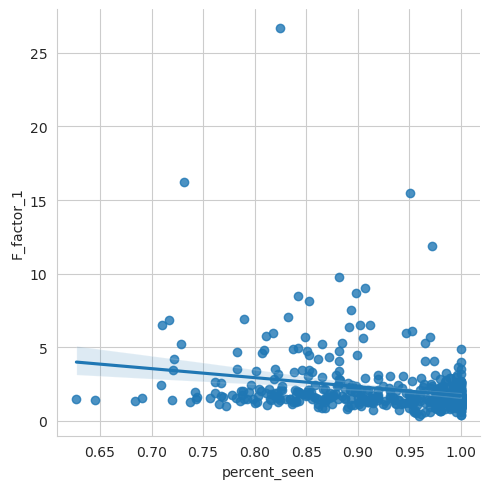

In [11]:
sns.lmplot(data = features_df, x = "percent_seen", y = "F_factor_1")
plt.show()

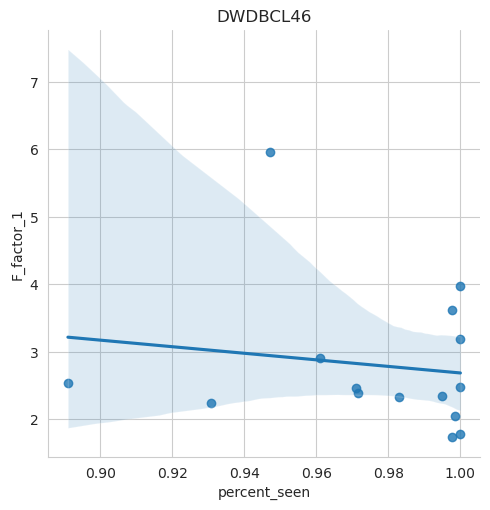

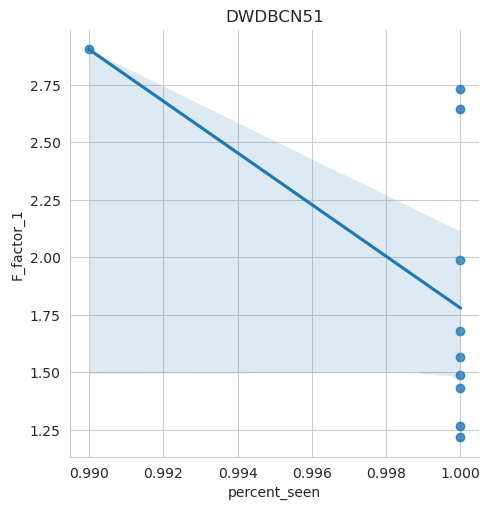

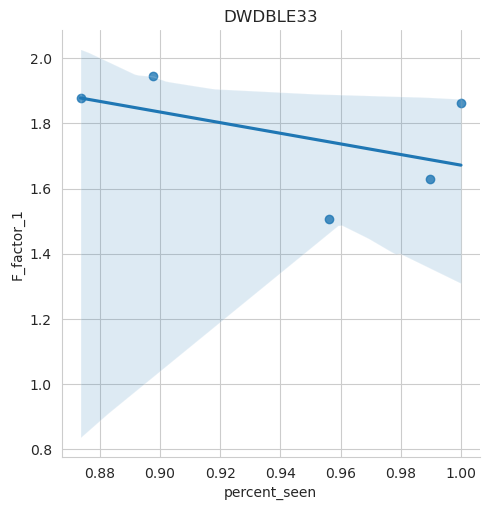

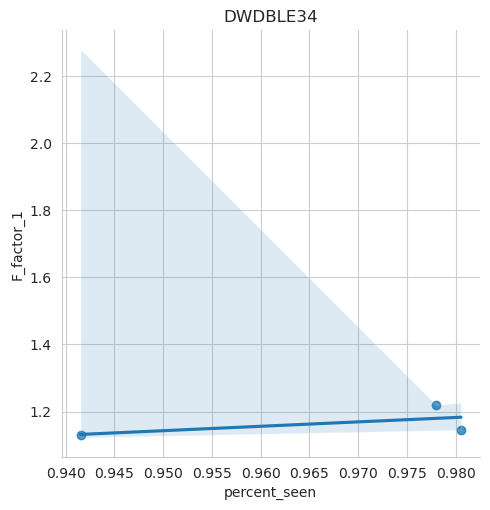

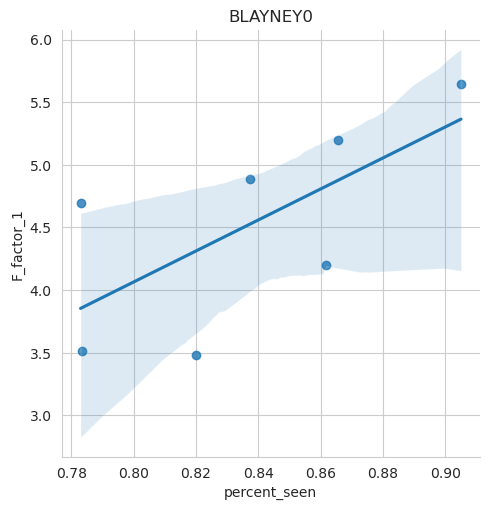

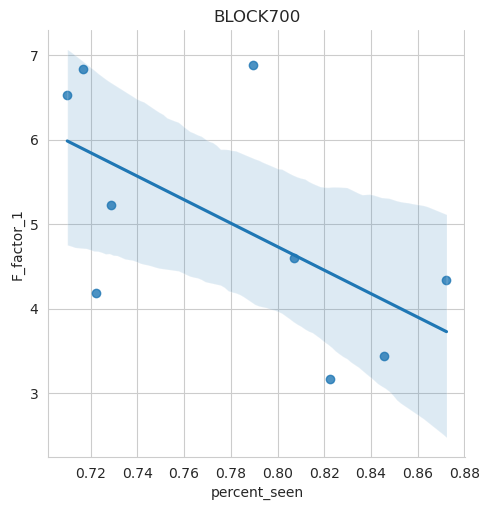

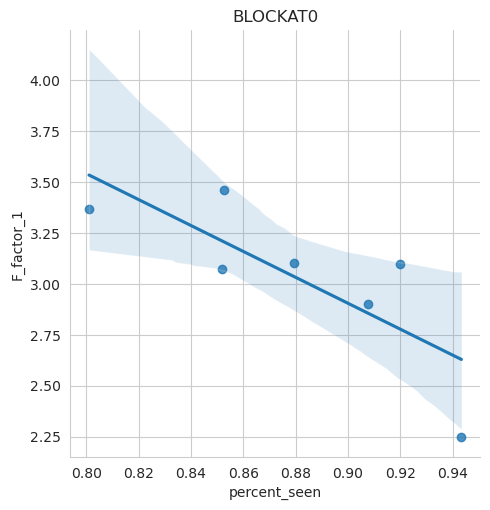

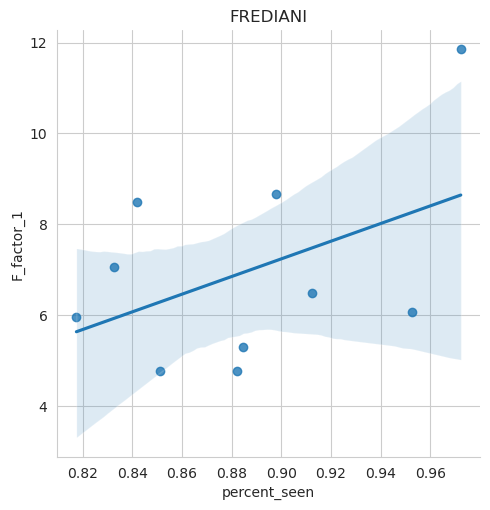

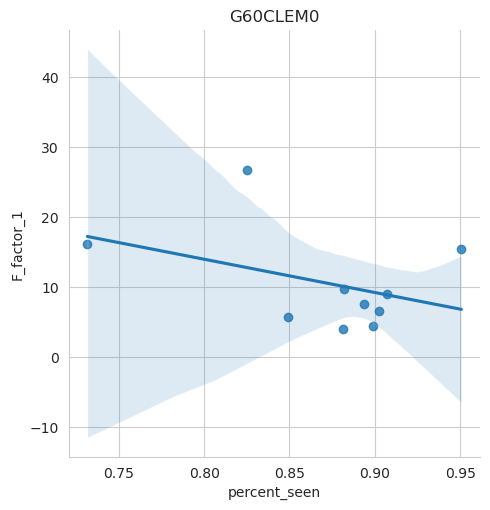

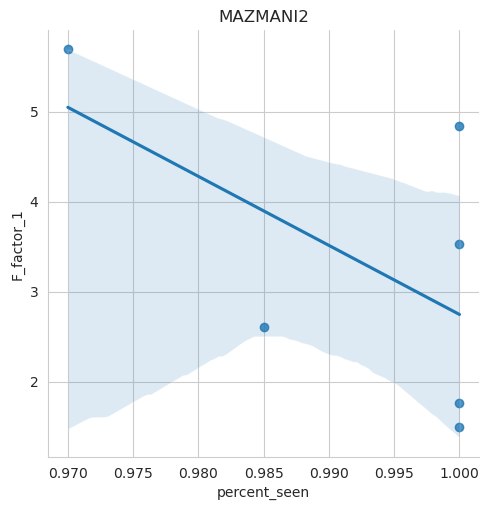

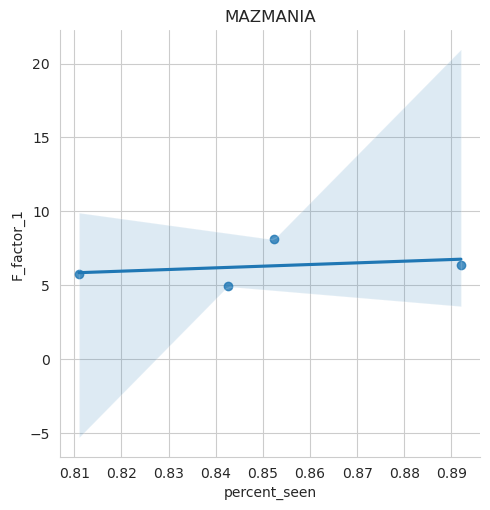

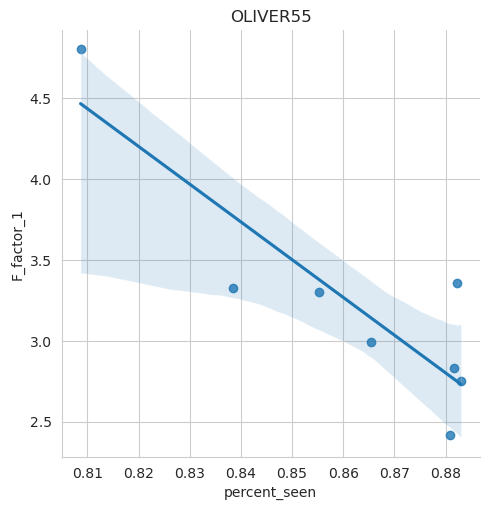

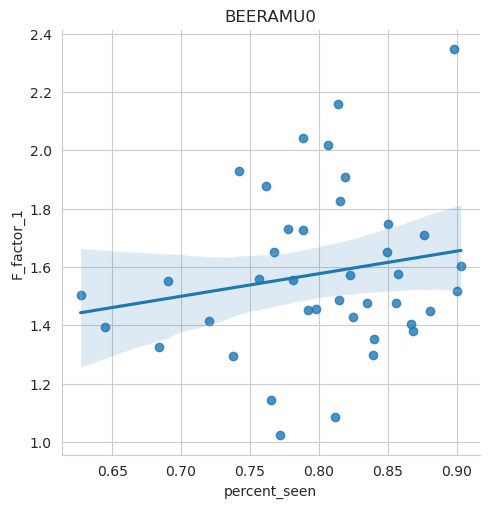

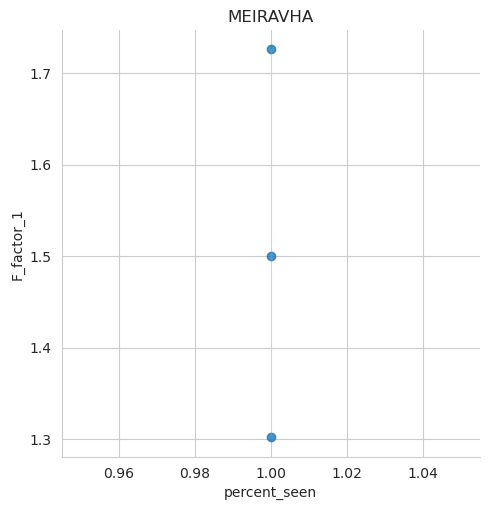

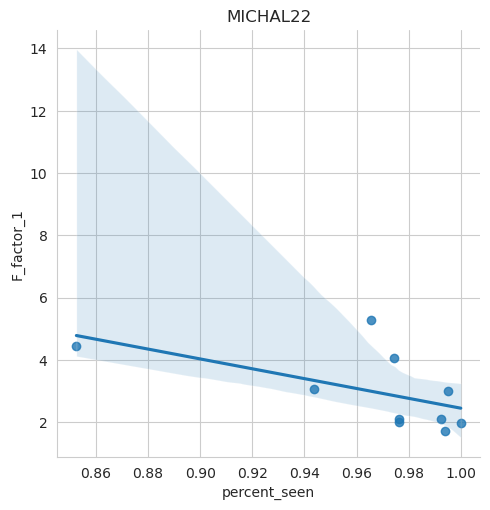

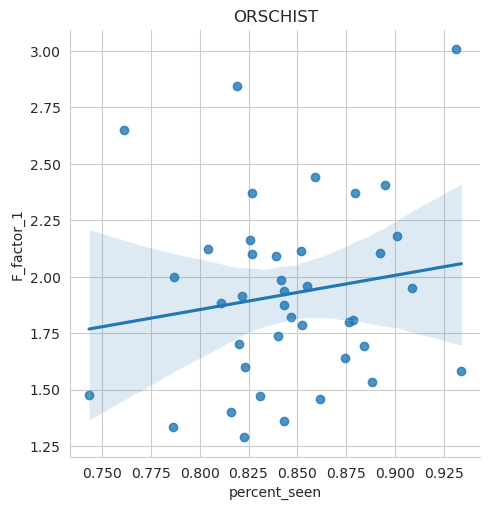

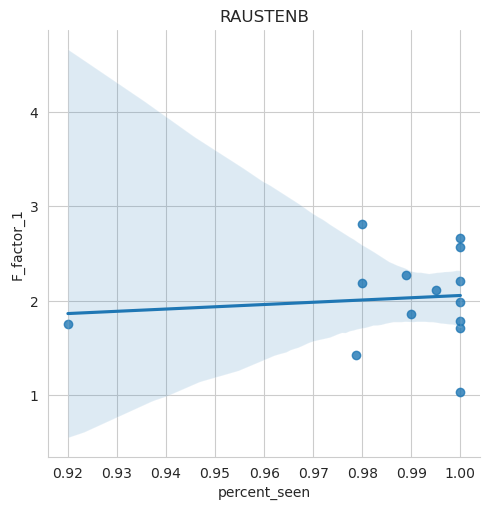

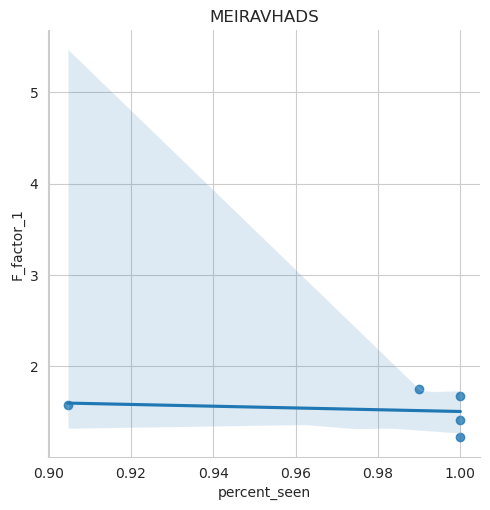

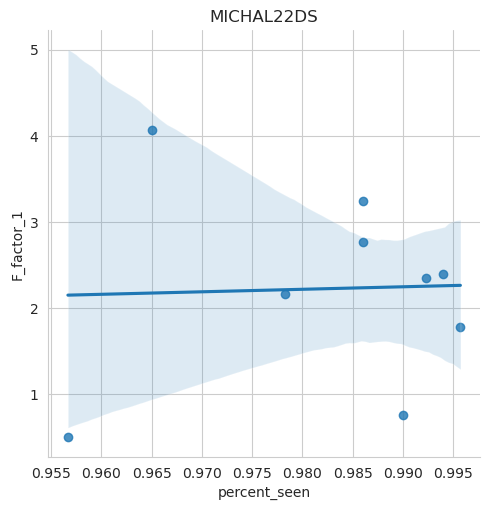

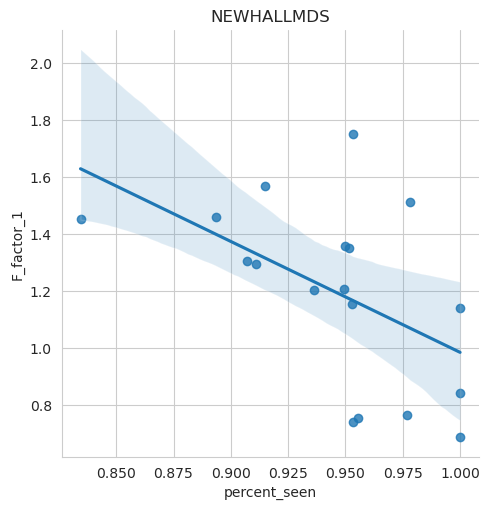

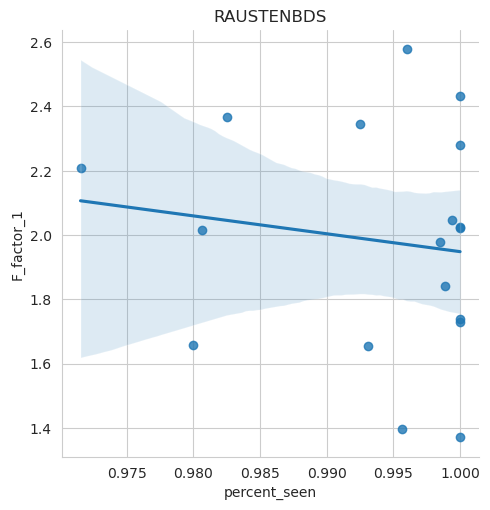

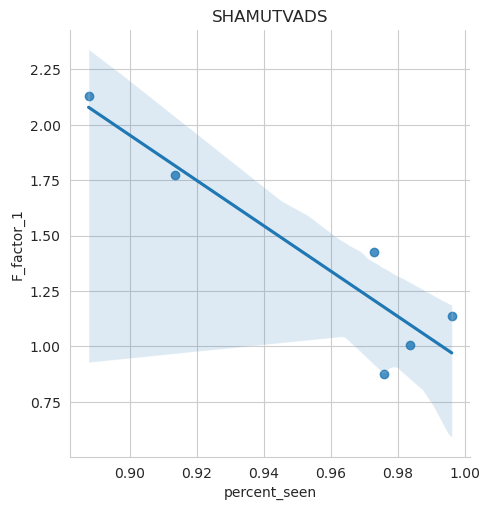

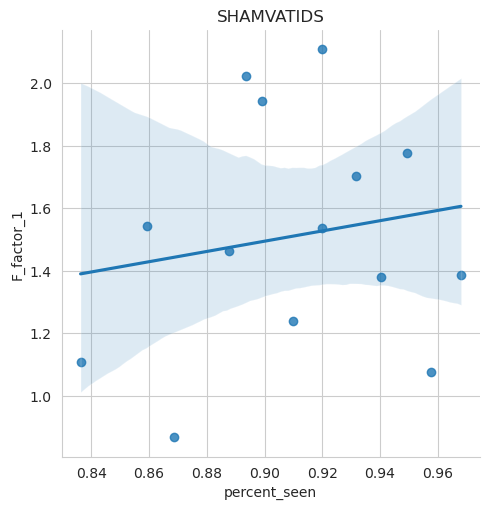

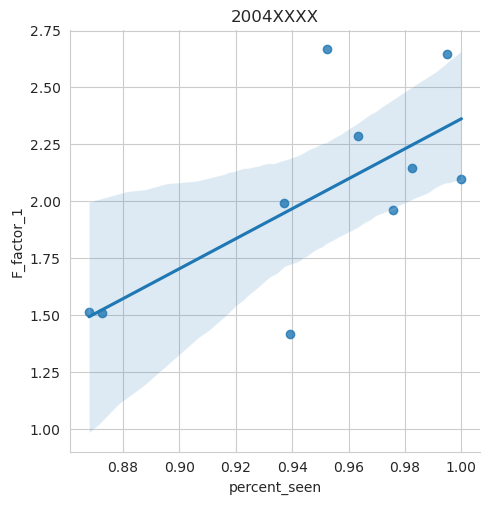

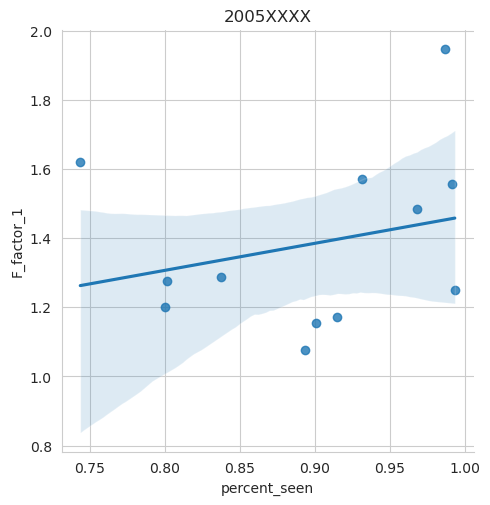

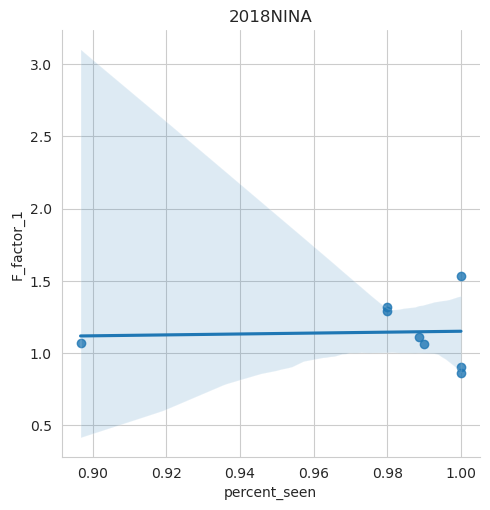

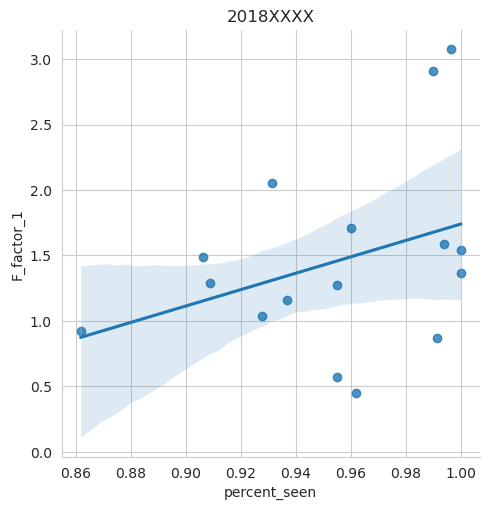

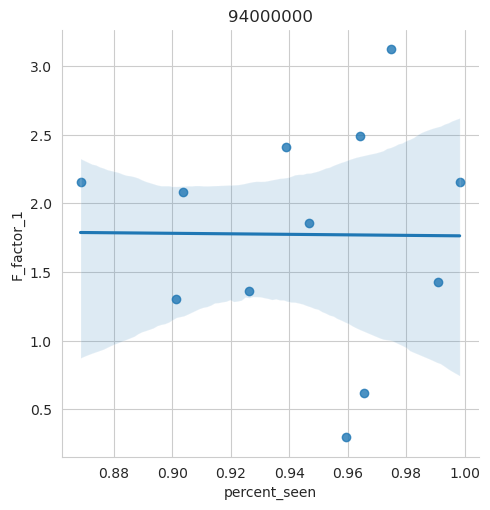

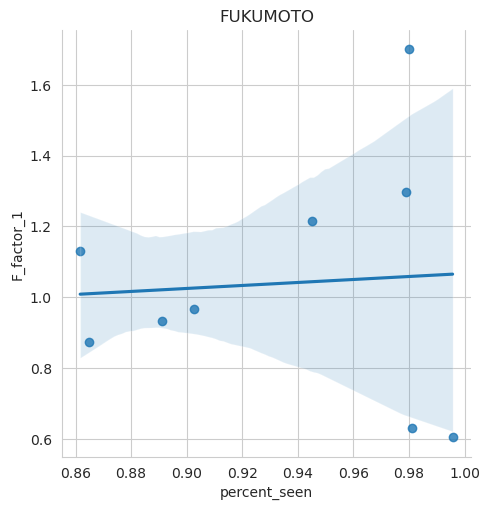

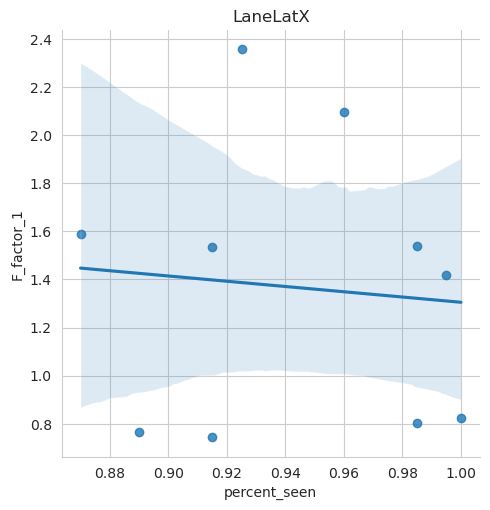

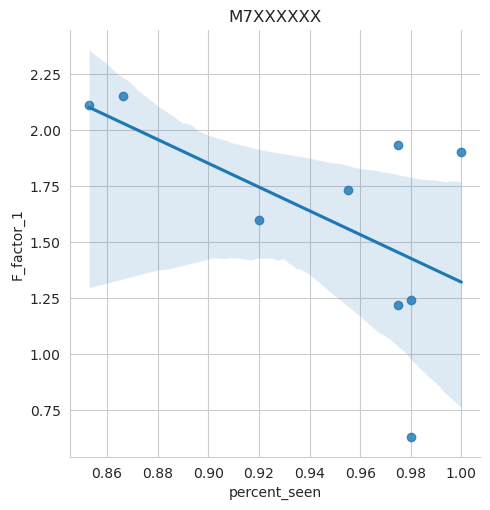

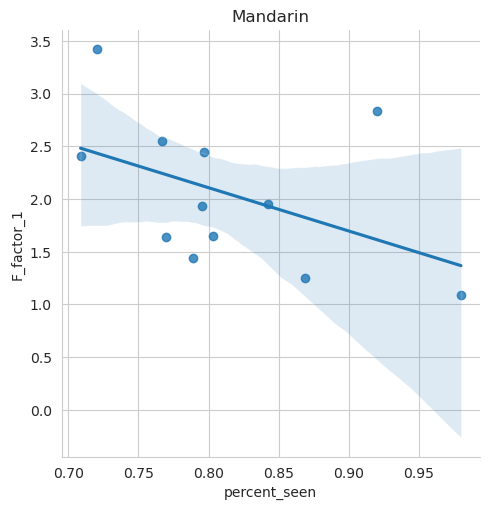

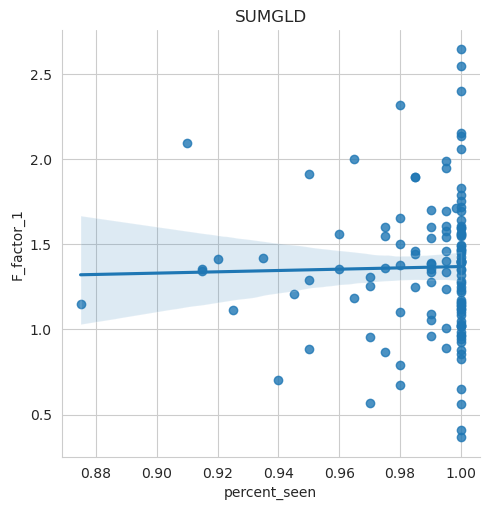

In [80]:
for block_name in features_df["block_name"].unique():
    block_features_df = features_df[features_df["block_name"] == block_name]
    sns.lmplot(data = block_features_df, x = "percent_seen", y = "F_factor_1")
#     ax = sns.lmplot(data = block_features_df, x = "percent_seen", y = "F_factor_1", hue="row_scan")
#     sns.regplot(data=block_features_df, x="percent_seen", y="F_factor_1", scatter_kws={'s': 2}, order=1,
#                 ci=0, ax=ax.axes[0, 0], x_ci=0, color="black", line_kws={"ls": "--"}, scatter=False)
    plt.title(block_name)
    plt.savefig(os.path.join("/home/fruitspec-lab/Downloads/PS_analysis_imgs", f"{block_name}.jpg"))
    plt.show()

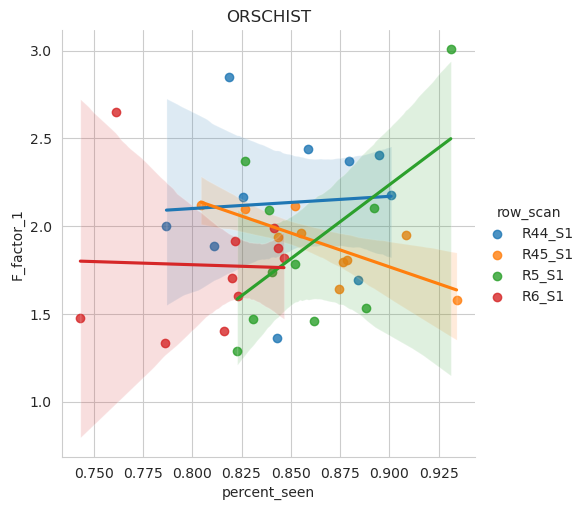

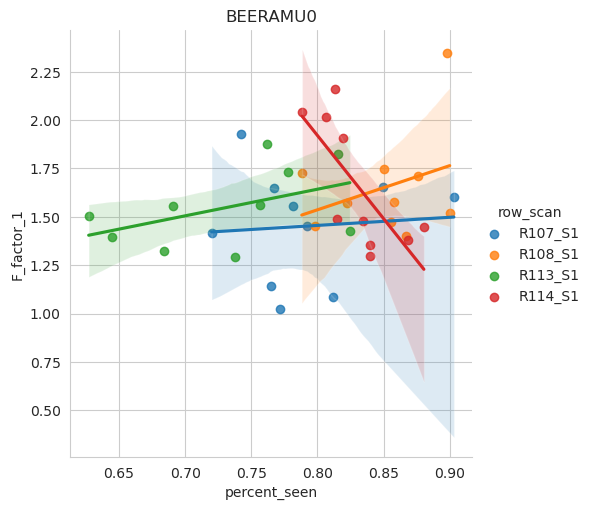

In [13]:
for block_name in ["ORSCHIST", "BEERAMU0"]:
    block_features_df = features_df[features_df["block_name"] == block_name]
    sns.lmplot(data = block_features_df, x = "percent_seen", y = "F_factor_1", hue = "row_scan")
#     ax = sns.lmplot(data = block_features_df, x = "percent_seen", y = "F_factor_1", hue="row_scan")
#     sns.regplot(data=block_features_df, x="percent_seen", y="F_factor_1", scatter_kws={'s': 2}, order=1,
#                 ci=0, ax=ax.axes[0, 0], x_ci=0, color="black", line_kws={"ls": "--"}, scatter=False)
    plt.title(block_name)
    plt.show()

In [14]:
features_df.groupby("block_name")['percent_seen'].std()

block_name
2004XXXX      0.046448
2005XXXX      0.084492
2018NINA      0.034465
2018XXXX      0.040629
94000000      0.039012
BEERAMU0      0.066125
BLAYNEY0      0.044997
BLOCK700      0.061587
BLOCKAT0      0.048542
DWDBCL46      0.032216
DWDBCN51      0.003162
DWDBLE33      0.055856
DWDBLE34      0.021826
FREDIANI      0.050975
FUKUMOTO      0.053733
G60CLEM0      0.059776
LaneLatX      0.046892
M7XXXXXX      0.053259
MAZMANI2      0.012550
MAZMANIA      0.033393
MEIRAVHA      0.000000
MEIRAVHADS    0.041752
MICHAL22      0.043613
MICHAL22DS    0.013579
Mandarin      0.078581
NEWHALLMDS    0.042023
OLIVER55      0.026858
ORSCHIST      0.041594
RAUSTENB      0.021302
RAUSTENBDS    0.008896
SHAMUTVADS    0.043655
SHAMVATIDS    0.038668
SUMGLD        0.022738
Name: percent_seen, dtype: float64

# F_modeling

### Load data

In [15]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]

## New features Precent_seen

In [56]:
df_f = features_df
df_f = df_f[df_f["customer"] != "MOTCHADS"].reset_index(drop=True)

In [57]:
cfg = OmegaConf.load("/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/model_config.yaml")
plot_fruit_var = get_plot_fruit_variety_df(cfg)
plot_fruit_var = pd.concat([plot_fruit_var, pd.DataFrame({"block_name" : ["ORSCHIST"],
                                         "fruit_type":["mandarin"]})]).reset_index(drop=True)
df_f = pd.merge(df_f, plot_fruit_var.drop_duplicates(), how="left", on="block_name")
hidden_range, cv_range, F_range, fruits_exclude = get_ranges(cfg)
df_f = process_fruit_type(df_f, fruits_exclude, cfg)

In [58]:
cv_cols = [f"cv{i}" for i in range(1,6)]
for cv_col in cv_cols:
    df_f[f"{cv_col}/percent_seen"] = df_f[cv_col] /df_f["percent_seen"]
    df_f[f"{cv_col}/percent_h_seen"] = df_f[cv_col] /df_f["percent_h_seen"]
    df_f[f"{cv_col}/percent_seen_top"] = df_f[cv_col] /df_f["percent_seen_top"]
    df_f[f"{cv_col}/full_tree"] = df_f[cv_col] /df_f["full_tree"]

### CV-F graphs

In [59]:
# plot_F_cv(df, min_samp="", hue=None, title="", col="", figsize=(10, 6), add_xy_line=True)

In [60]:
# for cv_col in cv_cols:
#     plot_F_cv(df_f, min_samp="", hue=None, title=f"{cv_col}/percent_seen", col=f"{cv_col}/percent_seen",
#               figsize=(10, 6), add_xy_line=True)
    

In [61]:
# for cv_col in cv_cols:
#     plot_F_cv(df_f, min_samp="", hue=None, title=f"{cv_col}/percent_h_seen", col=f"{cv_col}/percent_h_seen",
#               figsize=(10, 6), add_xy_line=True)
    

In [62]:
# for cv_col in cv_cols:
#     plot_F_cv(df_f, min_samp="", hue=None, title=f"{cv_col}/percent_seen_top", col=f"{cv_col}/percent_seen_top",
#               figsize=(10, 6), add_xy_line=True)
    

In [63]:
# for i in range(1,6):
#     plot_F_cv(df_f,i,"block_name", f"samp{i}")

In [64]:
# for i in range(1,6):
#     plot_F_cv(df_f,i,"side", f"samp{i}")

### Modeling

In [65]:
import sys
sys.path.append(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')

In [66]:
# df_f["row"] = df_f["real_row"]

df = df_f.reset_index(drop = True).copy()
X = df[["cv1"]]
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
print(model.intercept_, model.coef_)

true: 2847.0,    pred: 5790.684499408024. (103.40 %) (SUMGLD_R6)
true: 3932.0,    pred: 7108.0814624781615. (80.78 %) (SUMGLD_R4)
true: 3539.0,    pred: 6089.670114715341. (72.07 %) (SUMGLD_R3)
true: 1946.0,    pred: 3734.5775293331444. (91.91 %) (SUMGLD_R10)
true: 2231.0,    pred: 4271.808002539687. (91.48 %) (SUMGLD_R5)
true: 2047.0,    pred: 4164.590659285694. (103.45 %) (SUMGLD_R2)
true: 1544.0,    pred: 2762.053757511811. (78.89 %) (SUMGLD_R8)
true: 1645.0,    pred: 2213.1862181857196. (34.54 %) (SUMGLD_R9)
true: 6170.0,    pred: 8026.568691119969. (30.09 %) (ORSCHIST_R45)
true: 6680.0,    pred: 10029.621758465066. (50.14 %) (BEERAMU0_R114)
true: 6680.0,    pred: 10716.620350650544. (60.43 %) (BEERAMU0_R113)
true: 7374.0,    pred: 11173.042700396225. (51.52 %) (BEERAMU0_R108)
true: 6170.0,    pred: 7243.577396826093. (17.40 %) (ORSCHIST_R44)
true: 7374.0,    pred: 12646.894894114666. (71.51 %) (BEERAMU0_R107)
true: 4254.0,    pred: 5773.763686090367. (35.73 %) (ORSCHIST_R5)
true: 

In [67]:
# run_LROCV_by_block(df_f, ["cv1"])

In [72]:
cv_col = "cv1"
df_f_sub = df_f[(df_f["lemon"] + df_f["mandarin"]) == 0]
# df_f_sub = df_f[df_f["lemon"] == 1]
# df_f_sub = df_f[df_f["mandarin"] == 1]
print(cv_col)
print("\n" + "*" * 20 +"only cv col (with and wo intercept)" + "*" * 20 + "\n")
run_LBOCV_by_block(df_f_sub, cv_col=cv_col, fit_intercept=True)
run_LBOCV_by_block(df_f_sub, cv_col=cv_col, fit_intercept=False)

print("\n" + "*" * 20 +"only percent_seen interaction (with and wo intercept)"+ "*" * 20+ "\n")
run_LBOCV_by_block(df_f_sub, cv_col=[f"{cv_col}/percent_seen"], fit_intercept=True)
run_LBOCV_by_block(df_f_sub, cv_col=[f"{cv_col}/percent_seen"], fit_intercept=False)

print("\n" + "*" * 20 +"percent_seen + interaction (with and wo intercept)"+ "*" * 20+ "\n")
run_LBOCV_by_block(df_f_sub, cv_col=[cv_col, f"{cv_col}/percent_seen", "percent_seen"], fit_intercept=True)
run_LBOCV_by_block(df_f_sub, cv_col=[cv_col, f"{cv_col}/percent_seen", "percent_seen"], fit_intercept=False)

print("\n" + "*" * 20 +"percent_seen (with and wo intercept)"+ "*" * 20+ "\n")
run_LBOCV_by_block(df_f_sub, cv_col=[cv_col, "percent_seen"], fit_intercept=True)
run_LBOCV_by_block(df_f_sub, cv_col=[cv_col, "percent_seen"], fit_intercept=False)

# print("\n" + "*" * 20 +"percent_h_seen + interaction(with and wo intercept)"+ "*" * 20+ "\n")
# run_LBOCV_by_block(df_f, cv_col=[cv_col, f"{cv_col}/percent_h_seen", "percent_h_seen"], fit_intercept=True)
# run_LBOCV_by_block(df_f, cv_col=[cv_col, f"{cv_col}/percent_h_seen", "percent_h_seen"], fit_intercept=False)


cv1

********************only cv col (with and wo intercept)********************

true: 21577.0,    pred: 24541.584050685975. (13.74 %) (SUMGLD)
true: 2886.0,    pred: 3094.9344335903597. (7.24 %) (2018XXXX)
true: 3326.0,    pred: 2375.5197515817918. (28.58 %) (RAUSTENB)
true: 3540.0,    pred: 2678.9656008523007. (24.32 %) (94000000)
true: 3006.0,    pred: 3008.607371429959. (0.09 %) (2005XXXX)
true: 1349.0,    pred: 1634.8456330612373. (21.19 %) (LaneLatX)
true: 2986.0,    pred: 2036.6622322748362. (31.79 %) (2004XXXX)
true: 1080.0,    pred: 1080.1261481982547. (0.01 %) (M7XXXXXX)
true: 1276.0,    pred: 1799.3028438427136. (41.01 %) (FUKUMOTO)
true: 1147.0,    pred: 1481.9867701570122. (29.21 %) (2018NINA)
0.38689349821965086 0.13894633761280512
(0.19717691708169055, 0.13252369648309067)
[1.12890427]
true: 21577.0,    pred: 23142.74815599096. (7.26 %) (SUMGLD)
true: 2886.0,    pred: 3063.302168565077. (6.14 %) (2018XXXX)
true: 3326.0,    pred: 2302.0827925953827. (30.79 %) (RAUSTENB)
